Masa real: 6
Masa estimada (subrogado): 6.0
Error en estimación: 0.0000
Mejor match: 0.0495
Tiempo subrogado: 2.4343 s
Tiempo exacto (generación de onda): 0.2791 s


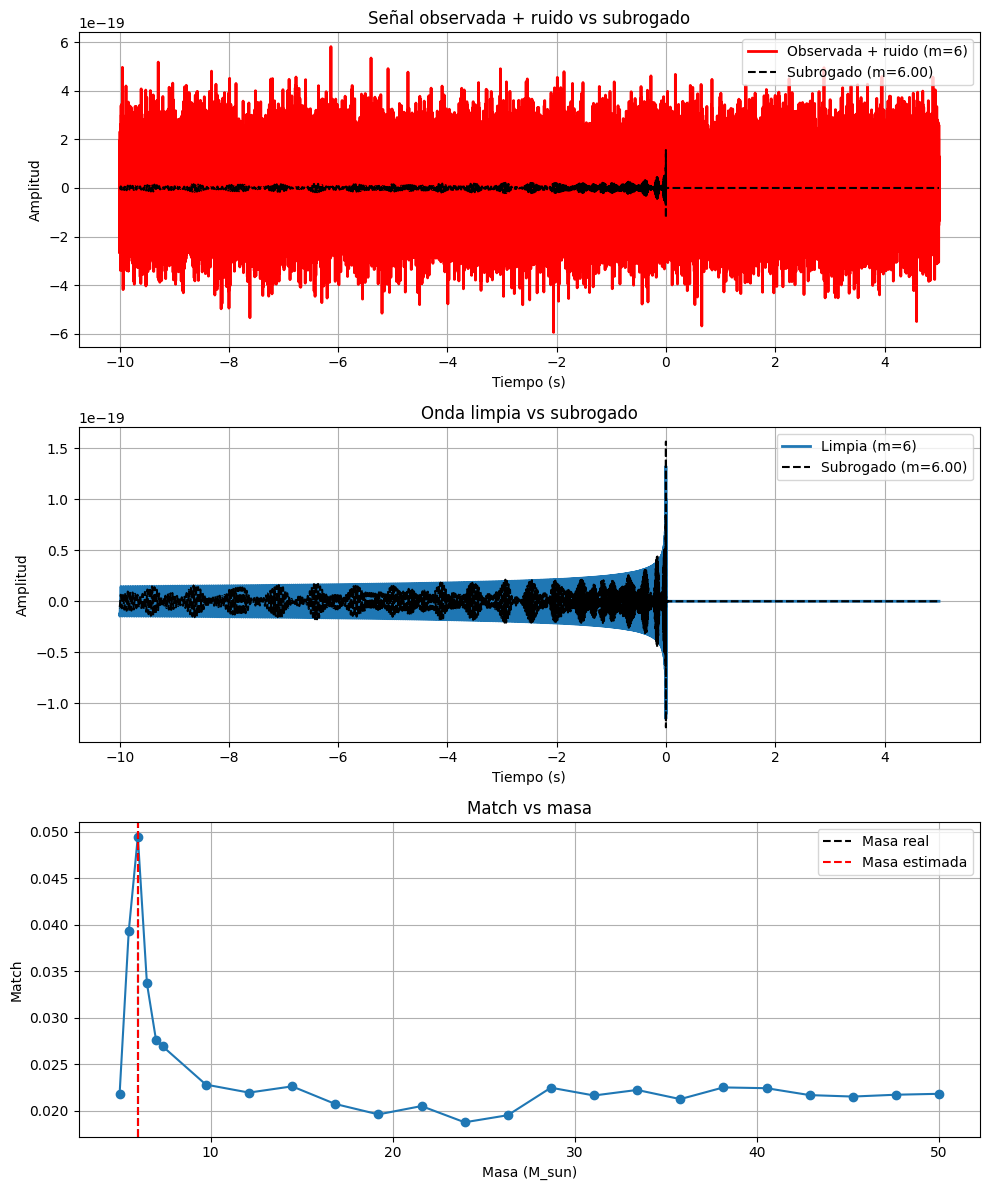

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.types import TimeSeries
from scipy.interpolate import Rbf
from pycbc.psd import aLIGOZeroDetHighPower

# ================================
# Configuración reproducible
# ================================
np.random.seed(42)
delta_t = 1.0 / 4096
f_low = 20.0
apx = "SEOBNRv4_ROM"

# ================================
# Función para centrar la onda
# ================================
def safe_time_slice(h, t_before=10, t_after=5):
    t_peak = h.sample_times[np.argmax(abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

# ================================
# Señal limpia y señal observada con ruido
# ================================
m_real = 6
hp_clean, _ = get_td_waveform(approximant=apx,
                              mass1=m_real, mass2=m_real,
                              delta_t=delta_t, f_lower=f_low)
hp_clean = safe_time_slice(hp_clean, t_before=10, t_after=5)
hp_clean_np = hp_clean.numpy()
times = hp_clean.sample_times.numpy()
N = len(hp_clean_np)

# Señal observada (con ruido)
sigma_noise = np.max(np.abs(hp_clean_np))
noise = np.random.normal(0, sigma_noise, size=N)
hp_obs = hp_clean_np + noise

# ================================
# Conjunto de entrenamiento
# ================================
mass_range = np.unique(np.concatenate([
    np.linspace(5, 50, 20),
    [5, 5.5, 6, 6.5, 7]
]))

W_list = []
for m in mass_range:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h, t_before=10, t_after=5)
    h_arr = np.zeros(N)
    L = min(len(h.numpy()), N)
    h_arr[:L] = h.numpy()[:L]
    W_list.append(h_arr)

W = np.array(W_list).T

# ================================
# Base reducida (SVD)
# ================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = min(50, U.shape[1])
basis = U[:, :k]
coeffs = basis.T @ W

# ================================
# Interpoladores (RBF)
# ================================
rbf_list = [Rbf(mass_range, coeffs[i, :], function="multiquadric", smooth=0.01) for i in range(k)]

def surrogate(m):
    coeff_pred = np.array([rbf(m) for rbf in rbf_list])
    return basis @ coeff_pred

# ================================
# Estimación de masa a partir de la señal observada
# ================================
matches = []
start_sub = time.time()
for m in mass_range:
    h_try = surrogate(m)
    ts_obs = TimeSeries(hp_obs, delta_t=delta_t)
    ts_try = TimeSeries(h_try, delta_t=delta_t)

    flen = len(ts_obs) // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, ts_obs.delta_f, f_low)
    mm, _ = match(ts_obs, ts_try, psd=psd, low_frequency_cutoff=f_low)
    matches.append(mm)
time_sub = time.time() - start_sub

best_idx = np.argmax(matches)
m_est = mass_range[best_idx]
best_match = matches[best_idx]
error_m = abs(m_est - m_real)

# ================================
# Tiempo de generación exacta
# ================================
start_exact = time.time()
h_exact, _ = get_td_waveform(approximant=apx,
                             mass1=m_real, mass2=m_real,
                             delta_t=delta_t, f_lower=f_low)
h_exact = safe_time_slice(h_exact, t_before=10, t_after=5)
h_exact_arr = np.zeros(N)
L = min(len(h_exact.numpy()), N)
h_exact_arr[:L] = h_exact.numpy()[:L]
time_exact = time.time() - start_exact

# ================================
# Resultados
# ================================
print(f"Masa real: {m_real}")
print(f"Masa estimada (subrogado): {m_est}")
print(f"Error en estimación: {error_m:.4f}")
print(f"Mejor match: {best_match:.4f}")
print(f"Tiempo subrogado: {time_sub:.4f} s")
print(f"Tiempo exacto (generación de onda): {time_exact:.4f} s")

# ================================
# Gráficos
# ================================
plt.figure(figsize=(10,12))

# Gráfico 1: señal observada + ruido vs subrogado
plt.subplot(3,1,1)
plt.plot(times, hp_obs,color='red', label=f"Observada + ruido (m={m_real})", lw=2)
plt.plot(times, surrogate(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal observada + ruido vs subrogado")
plt.legend()
plt.grid()

# Gráfico 2: onda limpia vs subrogado
plt.subplot(3,1,2)
plt.plot(times, hp_clean_np, label=f"Limpia (m={m_real})", lw=2)
plt.plot(times, surrogate(m_est), "--", color='black', label=f"Subrogado (m={m_est:.2f})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Onda limpia vs subrogado")
plt.legend()
plt.grid()

# Gráfico 3: match vs masa
plt.subplot(3,1,3)
plt.plot(mass_range, matches, "-o")
plt.axvline(m_real, color="k", linestyle="--", label="Masa real")
plt.axvline(m_est, color="r", linestyle="--", label="Masa estimada")
plt.xlabel("Masa (M_sun)")
plt.ylabel("Match")
plt.title("Match vs masa")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

/tmp/ipykernel_961/1432384571.py:182: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl = UnivariateSpline(mass_train, coeffs[i, :], k=3, s=1e-6)


=== Resultados ===
DO_WHITEN: True | TAPER_ALPHA: 0.1 | ENERGY_TARGET: 0.999
Dimensión base (k): 16
Masa real: 6.000
Masa estimada (subrogado): 6.000
Error en estimación: 0.0000 M_sun
Mejor match (euclídeo en preprocesado): 0.0802
Tiempo barrido subrogado (todas las m): 0.0073 s
Tiempo surrogate(m) puro: 0.000871 s | comparar: 0.009069 s
Tiempo exacto (generación de onda): 0.2901 s
Val mismatch medio: 1.0048e+00 | máx: 1.1481e+00


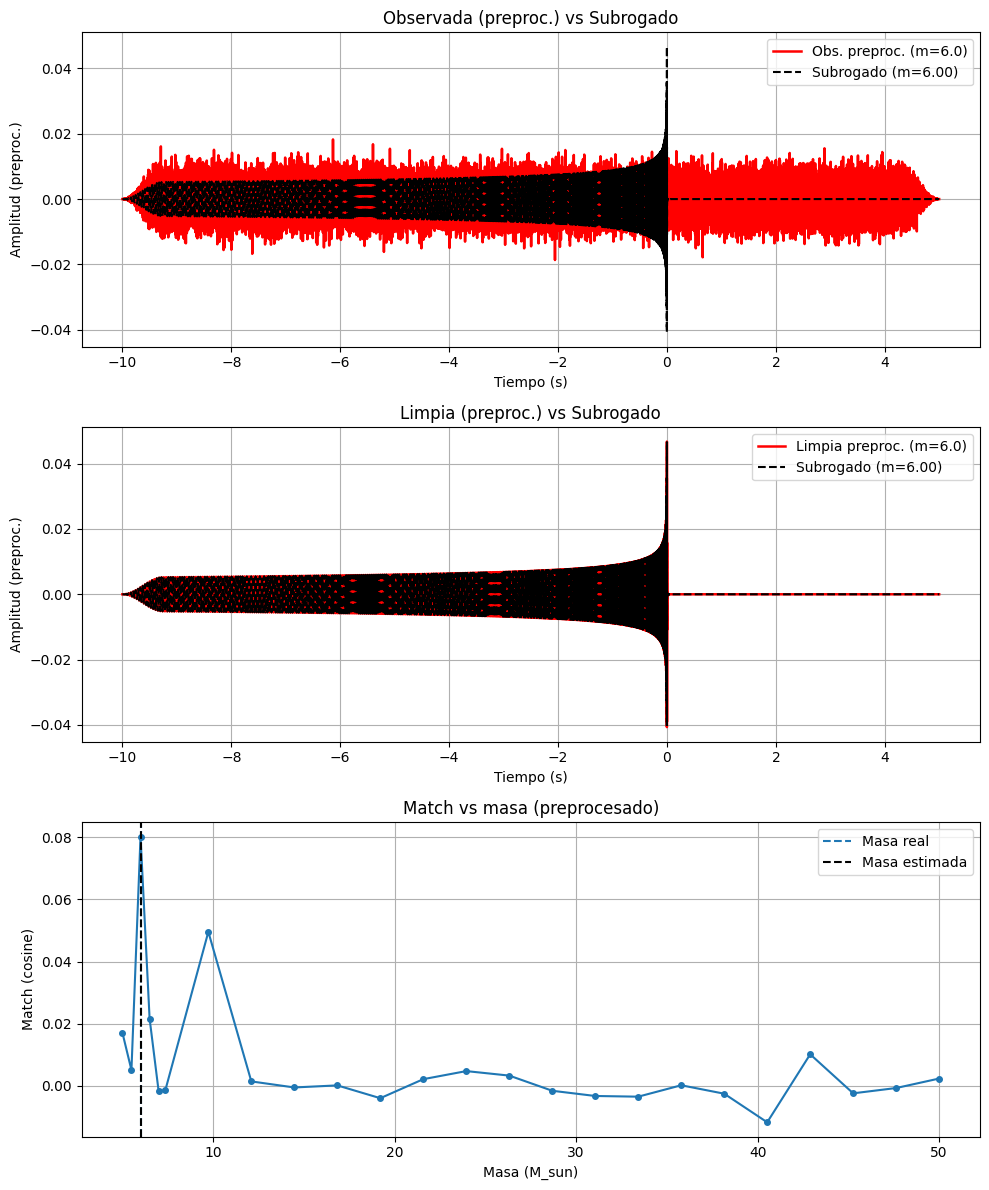

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- tukey compatible con distintas versiones de SciPy ---
try:
    from scipy.signal.windows import tukey
except ImportError:
    from scipy.signal import get_window
    def tukey(M, alpha=0.1):
        return get_window(("tukey", alpha), M)

from scipy.interpolate import UnivariateSpline

from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.psd import aLIGOZeroDetHighPower

# =========================================================
# Configuración reproducible
# =========================================================
np.random.seed(42)
delta_t = 1.0 / 4096.0
f_low = 20.0
apx = "SEOBNRv4_ROM"   # generador base (ROM del EOB)

# Toggles del experimento
DO_WHITEN = True        # blanqueo durante el preprocesado
TAPER_ALPHA = 0.1       # ventana Tukey
ENERGY_TARGET = 0.999   # varianza explicada para elegir k (99.9%)
VAL_EVERY_K = 3         # 1 de cada 3 masas queda para validación

# =========================================================
# Utilidades
# =========================================================
def safe_time_slice(h, t_before=10.0, t_after=5.0):
    """Centra en el pico de |h| y recorta una ventana alrededor."""
    t_peak = h.sample_times[np.argmax(np.abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

def taper_arr(arr, alpha=0.1):
    """Ventaneo Tukey para mitigar artefactos por truncado."""
    w = tukey(len(arr), alpha=alpha)
    return arr * w

def whiten(arr, delta_t, f_low=20.0):
    """
    Blanqueo simple: divide el espectro por sqrt(PSD).
    Retorna señal blanqueada en el dominio del tiempo.
    """
    N = len(arr)
    df = 1.0 / (N * delta_t)
    flen = N // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, df, f_low)
    # Evitar ceros numéricos
    psd = FrequencySeries(np.maximum(psd.numpy(), 1e-30), delta_f=df)

    hts = TimeSeries(arr, delta_t=delta_t)
    htilde = hts.to_frequencyseries()
    hwhite = (htilde / (psd ** 0.5)).to_timeseries()
    return hwhite.numpy()

def preprocess(h_ts_or_arr, N, delta_t, do_whiten=True, f_low=20.0, alpha=0.1):
    """
    Preprocesado coherente para TODAS las señales:
    - pad/trunc a longitud N
    - ventaneo (Tukey)
    - blanqueo (opcional)
    - normalización L2
    Entradas: TimeSeries (PyCBC) o ndarray (se convertirá a TimeSeries).
    """
    if isinstance(h_ts_or_arr, TimeSeries):
        arr = h_ts_or_arr.numpy()
    else:
        arr = np.asarray(h_ts_or_arr)

    out = np.zeros(N, dtype=float)
    L = min(len(arr), N)
    out[:L] = arr[:L]

    out = taper_arr(out, alpha=alpha)

    if do_whiten:
        out = whiten(out, delta_t, f_low=f_low)

    norm = np.linalg.norm(out)
    if norm > 0:
        out = out / norm

    return out

def choose_k_by_energy(S, energy=0.999):
    """Elige k por varianza explicada del SVD."""
    cum = np.cumsum(S**2) / np.sum(S**2)
    return int(np.searchsorted(cum, energy) + 1)

def split_train_val(x, every_k=3):
    """Separación simple hold-out: cada k-ésimo punto va a validación."""
    x = np.array(x)
    val_mask = np.zeros_like(x, dtype=bool)
    val_mask[::every_k] = True
    return x[~val_mask], x[val_mask]

def euclidean_match(x, y):
    """Cosine similarity en espacio preprocesado (normalizado)."""
    nx = x / (np.linalg.norm(x) + 1e-15)
    ny = y / (np.linalg.norm(y) + 1e-15)
    return float(np.dot(nx, ny))

def mismatch(x, y):
    return 1.0 - euclidean_match(x, y)

# =========================================================
# Señal objetivo (m1=m2=6) y señal observada con ruido
# =========================================================
m_real = 6.0
hp_clean, _ = get_td_waveform(approximant=apx,
                              mass1=m_real, mass2=m_real,
                              delta_t=delta_t, f_lower=f_low)
hp_clean = safe_time_slice(hp_clean, t_before=10, t_after=5)
hp_clean_np = hp_clean.numpy()
times = hp_clean.sample_times.numpy()
N = len(hp_clean_np)

# Señal observada (ruido fuerte como el original)
sigma_noise = np.max(np.abs(hp_clean_np))
noise = np.random.normal(0.0, sigma_noise, size=N)
hp_obs = hp_clean_np + noise

# Preprocesadas para comparación consistente
hp_clean_proc = preprocess(hp_clean, N, delta_t,
                           do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)
hp_obs_proc   = preprocess(TimeSeries(hp_obs, delta_t=delta_t), N, delta_t,
                           do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)

# =========================================================
# Conjunto de masas (train/val) y matriz W (solo train)
# =========================================================
mass_range = np.unique(np.concatenate([
    np.linspace(5, 50, 20),
    [5, 5.5, 6, 6.5, 7]
]))
mass_train, mass_val = split_train_val(mass_range, every_k=VAL_EVERY_K)

W_list = []
for m in mass_train:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h, t_before=10, t_after=5)
    h_proc = preprocess(h, N, delta_t,
                        do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)
    W_list.append(h_proc)

W = np.array(W_list).T  # [N x n_train]

# =========================================================
# Base reducida (SVD) + k por varianza explicada
# =========================================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = choose_k_by_energy(S, energy=ENERGY_TARGET)
basis = U[:, :k]
coeffs = basis.T @ W  # [k x n_train]

# =========================================================
# Interpoladores (splines cúbicos) de coeficientes vs masa
# =========================================================
interp_list = []
for i in range(k):
    # s controla el suavizado; ajustar si ves sobre/infraajuste
    spl = UnivariateSpline(mass_train, coeffs[i, :], k=3, s=1e-6)
    interp_list.append(spl)

def surrogate(m):
    """Predice h_proc(m) en el espacio preprocesado (blanqueado/normalizado si aplica)."""
    coeff_pred = np.array([spl(m) for spl in interp_list])
    return basis @ coeff_pred

# =========================================================
# Validación (sin ruido) para medir mismatch entre masas
# =========================================================
val_errors = []
for mv in mass_val:
    h_true, _ = get_td_waveform(approximant=apx,
                                mass1=mv, mass2=mv,
                                delta_t=delta_t, f_lower=f_low)
    h_true = safe_time_slice(h_true, t_before=10, t_after=5)
    h_true_proc = preprocess(h_true, N, delta_t,
                             do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)
    h_pred = surrogate(mv)
    val_errors.append(mismatch(h_true_proc, h_pred))

val_mismatch_mean = float(np.mean(val_errors)) if len(val_errors) else np.nan
val_mismatch_max  = float(np.max(val_errors))  if len(val_errors) else np.nan

# =========================================================
# Estimación de masa a partir de la señal observada (preproc)
# =========================================================
start_sub = time.time()
matches = []
for m in mass_range:
    h_try = surrogate(m)
    matches.append(euclidean_match(hp_obs_proc, h_try))
time_sub = time.time() - start_sub

best_idx = int(np.argmax(matches))
m_est = float(mass_range[best_idx])
best_match = float(matches[best_idx])
error_m = abs(m_est - m_real)

# =========================================================
# Tiempos de referencia
# =========================================================
start_exact = time.time()
h_exact, _ = get_td_waveform(approximant=apx,
                             mass1=m_real, mass2=m_real,
                             delta_t=delta_t, f_lower=f_low)
h_exact = safe_time_slice(h_exact, t_before=10, t_after=5)
h_exact_arr = np.zeros(N)
L = min(len(h_exact.numpy()), N)
h_exact_arr[:L] = h_exact.numpy()[:L]
time_exact = time.time() - start_exact

# Tiempo "online" puro del surrogate
m_test = 6.3
t0 = time.time()
h_pred_test = surrogate(m_test)
t1 = time.time()
_ = euclidean_match(hp_obs_proc, h_pred_test)
t2 = time.time()
time_surrogate_only = t1 - t0
time_compare_only   = t2 - t1

# =========================================================
# Resultados
# =========================================================
print("=== Resultados ===")
print(f"DO_WHITEN: {DO_WHITEN} | TAPER_ALPHA: {TAPER_ALPHA} | ENERGY_TARGET: {ENERGY_TARGET}")
print(f"Dimensión base (k): {k}")
print(f"Masa real: {m_real:.3f}")
print(f"Masa estimada (subrogado): {m_est:.3f}")
print(f"Error en estimación: {error_m:.4f} M_sun")
print(f"Mejor match (euclídeo en preprocesado): {best_match:.4f}")
print(f"Tiempo barrido subrogado (todas las m): {time_sub:.4f} s")
print(f"Tiempo surrogate(m) puro: {time_surrogate_only:.6f} s | comparar: {time_compare_only:.6f} s")
print(f"Tiempo exacto (generación de onda): {time_exact:.4f} s")
print(f"Val mismatch medio: {val_mismatch_mean:.4e} | máx: {val_mismatch_max:.4e}")

# =========================================================
# Gráficos (en el espacio PREPROCESADO para coherencia)
# =========================================================
plt.figure(figsize=(10, 12))

# 1) Observada (proc) vs subrogado en m_est
plt.subplot(3, 1, 1)
plt.plot(times, hp_obs_proc,color='red', label=f"Obs. preproc. (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (preproc.)")
plt.title("Observada (preproc.) vs Subrogado")
plt.legend()
plt.grid(True)

# 2) Limpia (proc) vs subrogado en m_est
plt.subplot(3, 1, 2)
plt.plot(times, hp_clean_proc,color='red', label=f"Limpia preproc. (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (preproc.)")
plt.title("Limpia (preproc.) vs Subrogado")
plt.legend()
plt.grid(True)

# 3) Match vs masa (euclídeo en preprocesado)
plt.subplot(3, 1, 3)
plt.plot(mass_range, matches, "-o", ms=4)
plt.axvline(m_real, linestyle="--", label="Masa real")
plt.axvline(m_est, linestyle="--",color='black', label="Masa estimada")
plt.xlabel("Masa (M_sun)")
plt.ylabel("Match (cosine)")
plt.title("Match vs masa (preprocesado)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


/tmp/ipykernel_961/3370418291.py:173: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl = UnivariateSpline(mass_train, coeffs[i, :], k=3, s=1e-6)


=== Resultados ===
DO_WHITEN: True | TAPER_ALPHA: 0.1 | ENERGY_TARGET: 0.999
Dimensión base (k): 16
Masa real: 6.000
Masa estimada (subrogado): 6.000
Error en estimación: 0.0000 M_sun
Mejor match (euclídeo en preprocesado): 0.0802
Tiempo barrido subrogado (todas las m): 0.0073 s
Tiempo surrogate(m) puro: 0.000826 s | comparar: 0.009579 s
Tiempo exacto (generación de onda): 0.3186 s
Val mismatch medio: 1.0048e+00 | máx: 1.1481e+00


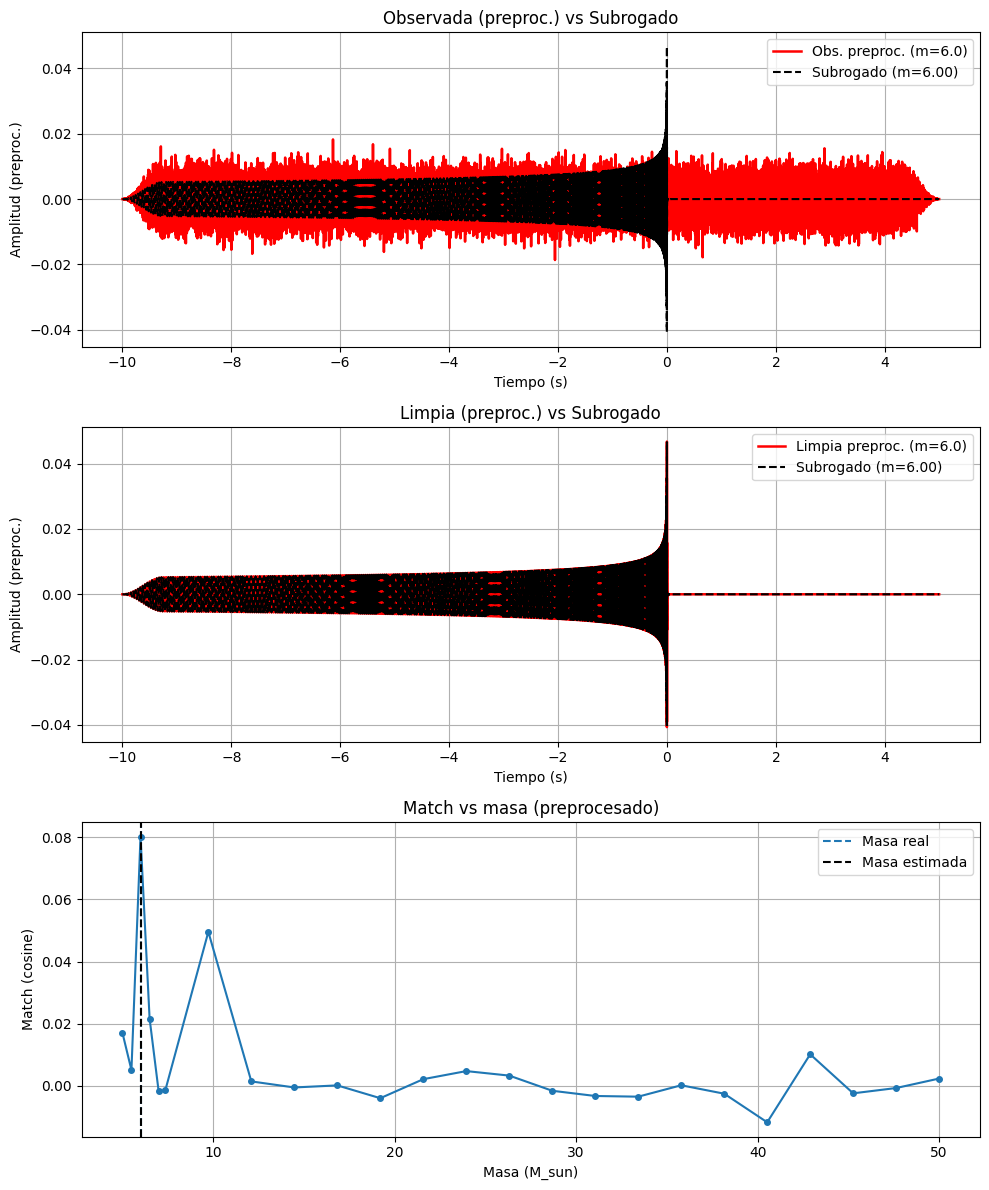

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- tukey compatible con distintas versiones de SciPy ---
try:
    from scipy.signal.windows import tukey
except ImportError:
    from scipy.signal import get_window
    def tukey(M, alpha=0.1):
        return get_window(("tukey", alpha), M)

from scipy.interpolate import UnivariateSpline

from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.psd import aLIGOZeroDetHighPower

# =========================================================
# Configuración reproducible
# =========================================================
np.random.seed(42)
delta_t = 1.0 / 4096.0
f_low = 20.0
apx = "SEOBNRv4_ROM"   # generador base (ROM del EOB)

# Toggles del experimento
DO_WHITEN = True        # blanqueo durante el preprocesado
TAPER_ALPHA = 0.1       # ventana Tukey
ENERGY_TARGET = 0.999   # varianza explicada para elegir k (99.9%)
VAL_EVERY_K = 3         # 1 de cada 3 masas queda para validación

# =========================================================
# Utilidades
# =========================================================
def safe_time_slice(h, t_before=10.0, t_after=5.0):
    """Centra en el pico de |h| y recorta una ventana alrededor."""
    t_peak = h.sample_times[np.argmax(np.abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

def taper_arr(arr, alpha=0.1):
    """Ventaneo Tukey para mitigar artefactos por truncado."""
    w = tukey(len(arr), alpha=alpha)
    return arr * w

def whiten(arr, delta_t, f_low=20.0):
    """
    Blanqueo simple: divide el espectro por sqrt(PSD).
    Retorna señal blanqueada en el dominio del tiempo.
    """
    N = len(arr)
    df = 1.0 / (N * delta_t)
    flen = N // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, df, f_low)
    # Evitar ceros numéricos
    psd = FrequencySeries(np.maximum(psd.numpy(), 1e-30), delta_f=df)

    hts = TimeSeries(arr, delta_t=delta_t)
    htilde = hts.to_frequencyseries()
    hwhite = (htilde / (psd ** 0.5)).to_timeseries()
    return hwhite.numpy()

def preprocess(h_ts_or_arr, N, delta_t, do_whiten=True, f_low=20.0, alpha=0.1):
    """
    Preprocesado coherente para TODAS las señales:
    - pad/trunc a longitud N
    - ventaneo (Tukey)
    - blanqueo (opcional)
    - normalización L2
    Entradas: TimeSeries (PyCBC) o ndarray (se convertirá a TimeSeries).
    """
    if isinstance(h_ts_or_arr, TimeSeries):
        arr = h_ts_or_arr.numpy()
    else:
        arr = np.asarray(h_ts_or_arr)

    out = np.zeros(N, dtype=float)
    L = min(len(arr), N)
    out[:L] = arr[:L]

    out = taper_arr(out, alpha=alpha)

    if do_whiten:
        out = whiten(out, delta_t, f_low=f_low)

    norm = np.linalg.norm(out)
    if norm > 0:
        out = out / norm

    return out

def choose_k_by_energy(S, energy=0.999):
    """Elige k por varianza explicada del SVD."""
    cum = np.cumsum(S**2) / np.sum(S**2)
    return int(np.searchsorted(cum, energy) + 1)

def split_train_val(x, every_k=3):
    """Separación simple hold-out: cada k-ésimo punto va a validación."""
    x = np.array(x)
    val_mask = np.zeros_like(x, dtype=bool)
    val_mask[::every_k] = True
    return x[~val_mask], x[val_mask]

def euclidean_match(x, y):
    """Cosine similarity en espacio preprocesado (normalizado)."""
    nx = x / (np.linalg.norm(x) + 1e-15)
    ny = y / (np.linalg.norm(y) + 1e-15)
    return float(np.dot(nx, ny))

def mismatch(x, y):
    return 1.0 - euclidean_match(x, y)

# =========================================================
# Señal objetivo (m1=m2=6) y señal observada con ruido
# =========================================================
m_real = 6.0
hp_clean, _ = get_td_waveform(approximant=apx,
                              mass1=m_real, mass2=m_real,
                              delta_t=delta_t, f_lower=f_low)
hp_clean = safe_time_slice(hp_clean, t_before=10, t_after=5)
hp_clean_np = hp_clean.numpy()
times = hp_clean.sample_times.numpy()
N = len(hp_clean_np)

# Señal observada (ruido fuerte como el original)
sigma_noise = np.max(np.abs(hp_clean_np))
noise = np.random.normal(0.0, sigma_noise, size=N)
hp_obs = hp_clean_np + noise

# Preprocesadas para comparación consistente
hp_clean_proc = preprocess(hp_clean, N, delta_t,
                           do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)
hp_obs_proc   = preprocess(TimeSeries(hp_obs, delta_t=delta_t), N, delta_t,
                           do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)

# =========================================================
# Conjunto de masas (train/val) y matriz W (solo train)
# =========================================================
mass_range = np.unique(np.concatenate([
    np.linspace(5, 50, 20),
    [5, 5.5, 6, 6.5, 7]
]))
mass_train, mass_val = split_train_val(mass_range, every_k=VAL_EVERY_K)

W_list = []
for m in mass_train:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h, t_before=10, t_after=5)
    h_proc = preprocess(h, N, delta_t,
                        do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)
    W_list.append(h_proc)

W = np.array(W_list).T  # [N x n_train]

# =========================================================
# Base reducida (SVD) + k por varianza explicada
# =========================================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = choose_k_by_energy(S, energy=ENERGY_TARGET)
basis = U[:, :k]
coeffs = basis.T @ W  # [k x n_train]

# =========================================================
# Interpoladores (splines cúbicos) de coeficientes vs masa
# =========================================================
interp_list = []
for i in range(k):
    # s controla el suavizado; ajustar si ves sobre/infraajuste
    spl = UnivariateSpline(mass_train, coeffs[i, :], k=3, s=1e-6)
    interp_list.append(spl)

def surrogate(m):
    """Predice h_proc(m) en el espacio preprocesado (blanqueado/normalizado si aplica)."""
    coeff_pred = np.array([spl(m) for spl in interp_list])
    return basis @ coeff_pred

# =========================================================
# Validación (sin ruido) para medir mismatch entre masas
# =========================================================
val_errors = []
for mv in mass_val:
    h_true, _ = get_td_waveform(approximant=apx,
                                mass1=mv, mass2=mv,
                                delta_t=delta_t, f_lower=f_low)
    h_true = safe_time_slice(h_true, t_before=10, t_after=5)
    h_true_proc = preprocess(h_true, N, delta_t,
                             do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)
    h_pred = surrogate(mv)
    val_errors.append(mismatch(h_true_proc, h_pred))

val_mismatch_mean = float(np.mean(val_errors)) if len(val_errors) else np.nan
val_mismatch_max  = float(np.max(val_errors))  if len(val_errors) else np.nan

# =========================================================
# Estimación de masa a partir de la señal observada (preproc)
# =========================================================
start_sub = time.time()
matches = []
for m in mass_range:
    h_try = surrogate(m)
    matches.append(euclidean_match(hp_obs_proc, h_try))
time_sub = time.time() - start_sub

best_idx = int(np.argmax(matches))
m_est = float(mass_range[best_idx])
best_match = float(matches[best_idx])
error_m = abs(m_est - m_real)

# =========================================================
# Tiempos de referencia
# =========================================================
start_exact = time.time()
h_exact, _ = get_td_waveform(approximant=apx,
                             mass1=m_real, mass2=m_real,
                             delta_t=delta_t, f_lower=f_low)
h_exact = safe_time_slice(h_exact, t_before=10, t_after=5)
h_exact_arr = np.zeros(N)
L = min(len(h_exact.numpy()), N)
h_exact_arr[:L] = h_exact.numpy()[:L]
time_exact = time.time() - start_exact

# Tiempo "online" puro del surrogate
m_test = 6.3
t0 = time.time()
h_pred_test = surrogate(m_test)
t1 = time.time()
_ = euclidean_match(hp_obs_proc, h_pred_test)
t2 = time.time()
time_surrogate_only = t1 - t0
time_compare_only   = t2 - t1

# =========================================================
# Resultados
# =========================================================
print("=== Resultados ===")
print(f"DO_WHITEN: {DO_WHITEN} | TAPER_ALPHA: {TAPER_ALPHA} | ENERGY_TARGET: {ENERGY_TARGET}")
print(f"Dimensión base (k): {k}")
print(f"Masa real: {m_real:.3f}")
print(f"Masa estimada (subrogado): {m_est:.3f}")
print(f"Error en estimación: {error_m:.4f} M_sun")
print(f"Mejor match (euclídeo en preprocesado): {best_match:.4f}")
print(f"Tiempo barrido subrogado (todas las m): {time_sub:.4f} s")
print(f"Tiempo surrogate(m) puro: {time_surrogate_only:.6f} s | comparar: {time_compare_only:.6f} s")
print(f"Tiempo exacto (generación de onda): {time_exact:.4f} s")
print(f"Val mismatch medio: {val_mismatch_mean:.4e} | máx: {val_mismatch_max:.4e}")

# =========================================================
# Gráficos (en el espacio PREPROCESADO para coherencia)
# =========================================================
plt.figure(figsize=(10, 12))

# 1) Observada (proc) vs subrogado en m_est
plt.subplot(3, 1, 1)
plt.plot(times, hp_obs_proc,color='red', label=f"Obs. preproc. (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (preproc.)")
plt.title("Observada (preproc.) vs Subrogado")
plt.legend()
plt.grid(True)

# 2) Limpia (proc) vs subrogado en m_est
plt.subplot(3, 1, 2)
plt.plot(times, hp_clean_proc,color='red', label=f"Limpia preproc. (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (preproc.)")
plt.title("Limpia (preproc.) vs Subrogado")
plt.legend()
plt.grid(True)

# 3) Match vs masa (euclídeo en preprocesado)
plt.subplot(3, 1, 3)
plt.plot(mass_range, matches, "-o", ms=4)
plt.axvline(m_real, linestyle="--", label="Masa real")
plt.axvline(m_est, linestyle="--",color='black', label="Masa estimada")
plt.xlabel("Masa (M_sun)")
plt.ylabel("Match (cosine)")
plt.title("Match vs masa (preprocesado)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


=== Resultados ===
DO_WHITEN: True | TAPER_ALPHA: 0.1 | ENERGY_TARGET: 0.999
Dimensión base (k): 16
Masa real: 6.000
Masa estimada (subrogado): 6.000
Error en estimación: 0.0000 M_sun
Mejor match (euclídeo en preprocesado): 0.0802
Tiempo barrido subrogado (todas las m): 0.0087 s
Tiempo surrogate(m) puro: 0.001101 s | comparar: 0.001964 s
Tiempo exacto (generación de onda): 0.2750 s
Val mismatch medio: 1.0917e+00 | máx: 1.4507e+00


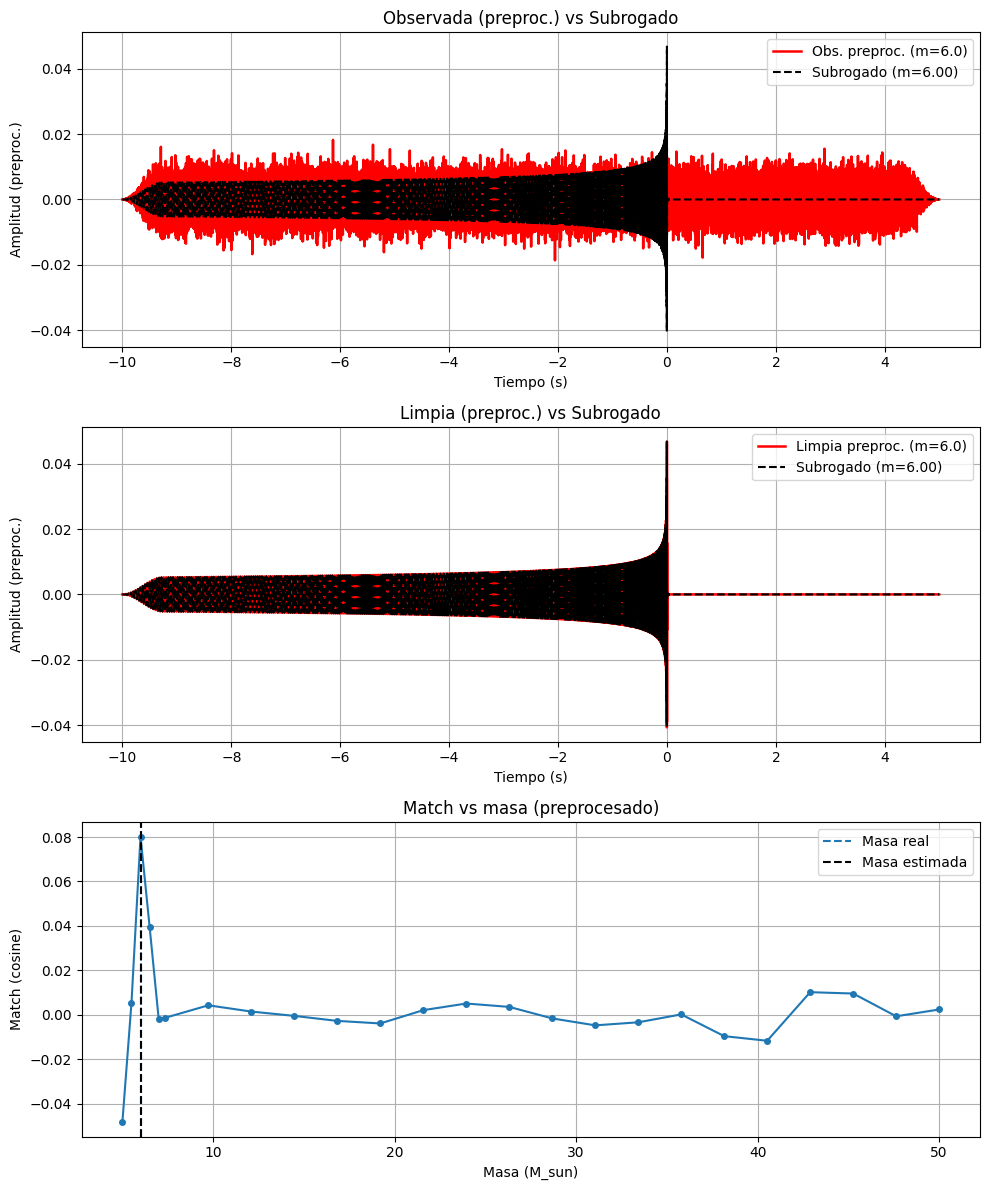

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- tukey compatible con distintas versiones de SciPy ---
try:
    from scipy.signal.windows import tukey
except ImportError:
    from scipy.signal import get_window
    def tukey(M, alpha=0.1):
        return get_window(("tukey", alpha), M)

# Cambiamos a InterpolatedUnivariateSpline (interpolación exacta)
from scipy.interpolate import InterpolatedUnivariateSpline

from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.psd import aLIGOZeroDetHighPower

# =========================================================
# Configuración reproducible
# =========================================================
np.random.seed(42)
delta_t = 1.0 / 4096.0
f_low = 20.0
apx = "SEOBNRv4_ROM"   # generador base (ROM del EOB)

# Toggles del experimento
DO_WHITEN = True        # blanqueo durante el preprocesado
TAPER_ALPHA = 0.1       # ventana Tukey
ENERGY_TARGET = 0.999   # varianza explicada para elegir k (99.9%)
VAL_EVERY_K = 3         # 1 de cada 3 masas queda para validación

# =========================================================
# Utilidades
# =========================================================
def safe_time_slice(h, t_before=10.0, t_after=5.0):
    """Centra en el pico de |h| y recorta una ventana alrededor."""
    t_peak = h.sample_times[np.argmax(np.abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

def taper_arr(arr, alpha=0.1):
    """Ventaneo Tukey para mitigar artefactos por truncado."""
    w = tukey(len(arr), alpha=alpha)
    return arr * w

def whiten(arr, delta_t, f_low=20.0):
    """
    Blanqueo simple: divide el espectro por sqrt(PSD).
    Retorna señal blanqueada en el dominio del tiempo.
    """
    N = len(arr)
    df = 1.0 / (N * delta_t)
    flen = N // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, df, f_low)
    # Evitar ceros numéricos
    psd = FrequencySeries(np.maximum(psd.numpy(), 1e-30), delta_f=df)

    hts = TimeSeries(arr, delta_t=delta_t)
    htilde = hts.to_frequencyseries()
    hwhite = (htilde / (psd ** 0.5)).to_timeseries()
    return hwhite.numpy()

def preprocess(h_ts_or_arr, N, delta_t, do_whiten=True, f_low=20.0, alpha=0.1):
    """
    Preprocesado coherente para TODAS las señales:
    - pad/trunc a longitud N
    - ventaneo (Tukey)
    - blanqueo (opcional)
    - normalización L2
    Entradas: TimeSeries (PyCBC) o ndarray (se convertirá a TimeSeries).
    """
    if isinstance(h_ts_or_arr, TimeSeries):
        arr = h_ts_or_arr.numpy()
    else:
        arr = np.asarray(h_ts_or_arr)

    out = np.zeros(N, dtype=float)
    L = min(len(arr), N)
    out[:L] = arr[:L]

    out = taper_arr(out, alpha=alpha)

    if do_whiten:
        out = whiten(out, delta_t, f_low=f_low)

    norm = np.linalg.norm(out)
    if norm > 0:
        out = out / norm

    return out

def choose_k_by_energy(S, energy=0.999):
    """Elige k por varianza explicada del SVD."""
    cum = np.cumsum(S**2) / np.sum(S**2)
    return int(np.searchsorted(cum, energy) + 1)

def split_train_val(x, every_k=3):
    """Separación simple hold-out: cada k-ésimo punto va a validación."""
    x = np.array(x)
    val_mask = np.zeros_like(x, dtype=bool)
    val_mask[::every_k] = True
    return x[~val_mask], x[val_mask]

def euclidean_match(x, y):
    """Cosine similarity en espacio preprocesado (normalizado)."""
    nx = x / (np.linalg.norm(x) + 1e-15)
    ny = y / (np.linalg.norm(y) + 1e-15)
    return float(np.dot(nx, ny))

def mismatch(x, y):
    return 1.0 - euclidean_match(x, y)

# =========================================================
# Señal objetivo (m1=m2=6) y señal observada con ruido
# =========================================================
m_real = 6.0
hp_clean, _ = get_td_waveform(approximant=apx,
                              mass1=m_real, mass2=m_real,
                              delta_t=delta_t, f_lower=f_low)
hp_clean = safe_time_slice(hp_clean, t_before=10, t_after=5)
hp_clean_np = hp_clean.numpy()
times = hp_clean.sample_times.numpy()
N = len(hp_clean_np)

# Señal observada (ruido fuerte como el original)
sigma_noise = np.max(np.abs(hp_clean_np))
noise = np.random.normal(0.0, sigma_noise, size=N)
hp_obs = hp_clean_np + noise

# Preprocesadas para comparación consistente
hp_clean_proc = preprocess(hp_clean, N, delta_t,
                           do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)
hp_obs_proc   = preprocess(TimeSeries(hp_obs, delta_t=delta_t), N, delta_t,
                           do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)

# =========================================================
# Conjunto de masas (train/val) y matriz W (solo train)
# =========================================================
mass_range = np.unique(np.concatenate([
    np.linspace(5, 50, 20),
    [5, 5.5, 6, 6.5, 7]
]))
mass_train, mass_val = split_train_val(mass_range, every_k=VAL_EVERY_K)

W_list = []
for m in mass_train:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h, t_before=10, t_after=5)
    h_proc = preprocess(h, N, delta_t,
                        do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)
    W_list.append(h_proc)

W = np.array(W_list).T  # [N x n_train]

# =========================================================
# Base reducida (SVD) + k por varianza explicada
# =========================================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = choose_k_by_energy(S, energy=ENERGY_TARGET)
basis = U[:, :k]
coeffs = basis.T @ W  # [k x n_train]

# =========================================================
# Interpoladores (splines cúbicos interpolantes) de coeficientes vs masa
# =========================================================
interp_list = []
for i in range(k):
    # Interpolación exacta (sin parámetro de suavizado)
    spl = InterpolatedUnivariateSpline(mass_train, coeffs[i, :], k=3)
    interp_list.append(spl)

def surrogate(m):
    """Predice h_proc(m) en el espacio preprocesado (blanqueado/normalizado si aplica)."""
    coeff_pred = np.array([spl(m) for spl in interp_list])
    return basis @ coeff_pred

# =========================================================
# Validación (sin ruido) para medir mismatch entre masas
# =========================================================
val_errors = []
for mv in mass_val:
    h_true, _ = get_td_waveform(approximant=apx,
                                mass1=mv, mass2=mv,
                                delta_t=delta_t, f_lower=f_low)
    h_true = safe_time_slice(h_true, t_before=10, t_after=5)
    h_true_proc = preprocess(h_true, N, delta_t,
                             do_whiten=DO_WHITEN, f_low=f_low, alpha=TAPER_ALPHA)
    h_pred = surrogate(mv)
    val_errors.append(mismatch(h_true_proc, h_pred))

val_mismatch_mean = float(np.mean(val_errors)) if len(val_errors) else np.nan
val_mismatch_max  = float(np.max(val_errors))  if len(val_errors) else np.nan

# =========================================================
# Estimación de masa a partir de la señal observada (preproc)
# =========================================================
start_sub = time.time()
matches = []
for m in mass_range:
    h_try = surrogate(m)
    matches.append(euclidean_match(hp_obs_proc, h_try))
time_sub = time.time() - start_sub

best_idx = int(np.argmax(matches))
m_est = float(mass_range[best_idx])
best_match = float(matches[best_idx])
error_m = abs(m_est - m_real)

# =========================================================
# Tiempos de referencia
# =========================================================
start_exact = time.time()
h_exact, _ = get_td_waveform(approximant=apx,
                             mass1=m_real, mass2=m_real,
                             delta_t=delta_t, f_lower=f_low)
h_exact = safe_time_slice(h_exact, t_before=10, t_after=5)
h_exact_arr = np.zeros(N)
L = min(len(h_exact.numpy()), N)
h_exact_arr[:L] = h_exact.numpy()[:L]
time_exact = time.time() - start_exact

# Tiempo "online" puro del surrogate
m_test = 6.3
t0 = time.time()
h_pred_test = surrogate(m_test)
t1 = time.time()
_ = euclidean_match(hp_obs_proc, h_pred_test)
t2 = time.time()
time_surrogate_only = t1 - t0
time_compare_only   = t2 - t1

# =========================================================
# Resultados
# =========================================================
print("=== Resultados ===")
print(f"DO_WHITEN: {DO_WHITEN} | TAPER_ALPHA: {TAPER_ALPHA} | ENERGY_TARGET: {ENERGY_TARGET}")
print(f"Dimensión base (k): {k}")
print(f"Masa real: {m_real:.3f}")
print(f"Masa estimada (subrogado): {m_est:.3f}")
print(f"Error en estimación: {error_m:.4f} M_sun")
print(f"Mejor match (euclídeo en preprocesado): {best_match:.4f}")
print(f"Tiempo barrido subrogado (todas las m): {time_sub:.4f} s")
print(f"Tiempo surrogate(m) puro: {time_surrogate_only:.6f} s | comparar: {time_compare_only:.6f} s")
print(f"Tiempo exacto (generación de onda): {time_exact:.4f} s")
print(f"Val mismatch medio: {val_mismatch_mean:.4e} | máx: {val_mismatch_max:.4e}")

# =========================================================
# Gráficos (en el espacio PREPROCESADO para coherencia)
# =========================================================
plt.figure(figsize=(10, 12))

# 1) Observada (proc) vs subrogado en m_est
plt.subplot(3, 1, 1)
plt.plot(times, hp_obs_proc,color='red', label=f"Obs. preproc. (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (preproc.)")
plt.title("Observada (preproc.) vs Subrogado")
plt.legend()
plt.grid(True)

# 2) Limpia (proc) vs subrogado en m_est
plt.subplot(3, 1, 2)
plt.plot(times, hp_clean_proc,color='red', label=f"Limpia preproc. (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (preproc.)")
plt.title("Limpia (preproc.) vs Subrogado")
plt.legend()
plt.grid(True)

# 3) Match vs masa (euclídeo en preprocesado)
plt.subplot(3, 1, 3)
plt.plot(mass_range, matches, "-o", ms=4)
plt.axvline(m_real, linestyle="--", label="Masa real")
plt.axvline(m_est, linestyle="--",color='black', label="Masa estimada")
plt.xlabel("Masa (M_sun)")
plt.ylabel("Match (cosine)")
plt.title("Match vs masa (preprocesado)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


=== Resultados ===
TAPER_ALPHA: 0.05 | ENERGY_TARGET: 0.999
Dimensión base (k): 60
Masa real: 6.000
Masa estimada (subrogado): 6.000
Error en estimación: 0.0000 M_sun
Mejor match (PyCBC): 0.0667
Tiempo barrido subrogado (todas las m): 2.7687 s
Tiempo surrogate(m) puro: 0.002482 s | comparar: 0.057397 s
Tiempo exacto (generación de onda): 0.2967 s


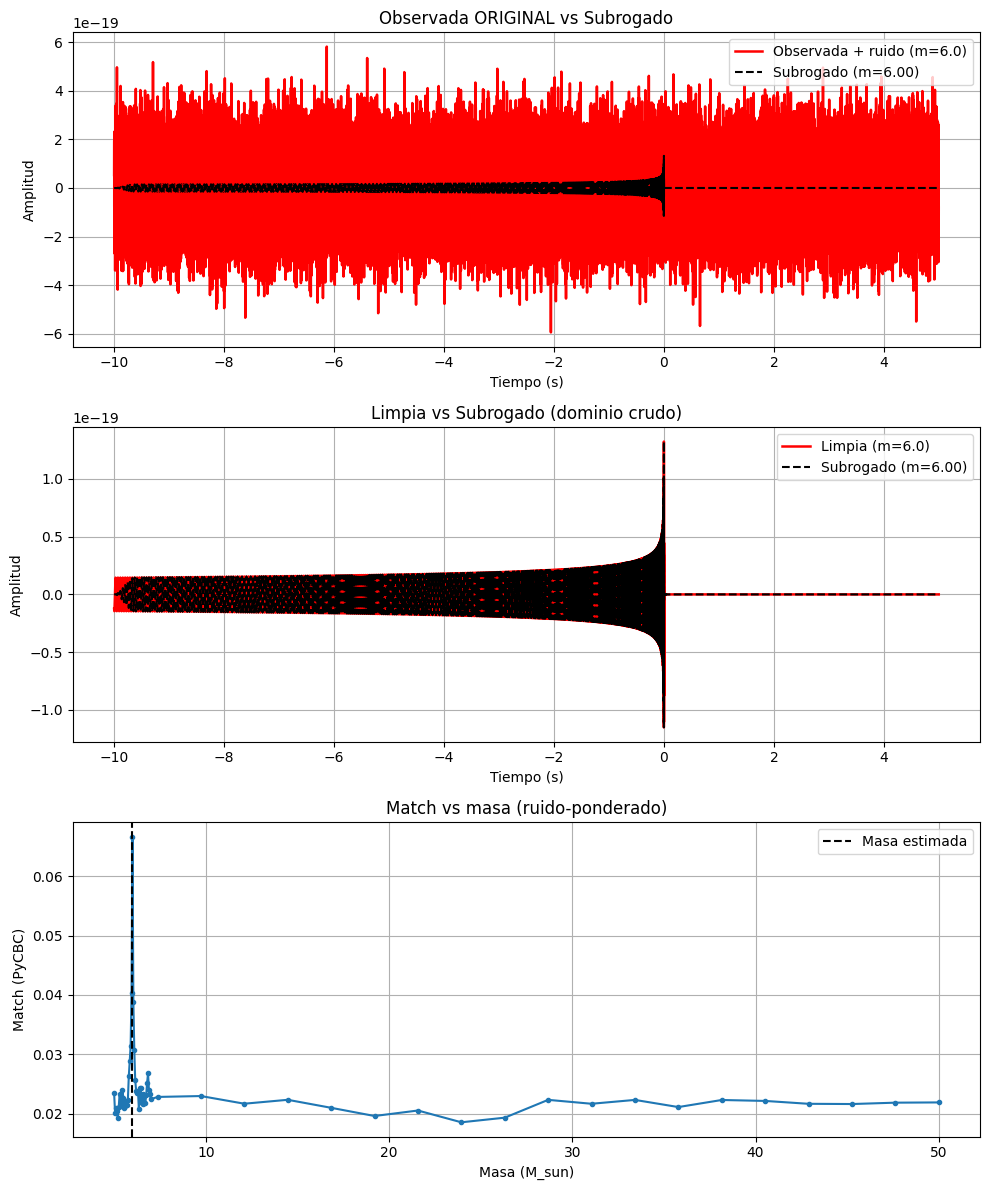

In [20]:
# -*- coding: utf-8 -*-
"""
Subrogado 1D (m1 = m2) en dominio crudo + PCHIP
- Base reducida (SVD) construida sobre ondas "crudas" (sin blanqueo/normalización)
- Interpolación estable de coeficientes con PCHIP
- Match con pycbc.filter.match (PSD aLIGO, max. sobre tiempo/fase)
- Gráfico 1: onda observada ORIGINAL vs subrogado (no preproc)

Requisitos: numpy, matplotlib, scipy, pycbc
"""

import numpy as np
import matplotlib.pyplot as plt
import time

# tukey compatible con distintas versiones de SciPy
try:
    from scipy.signal.windows import tukey
except ImportError:
    from scipy.signal import get_window
    def tukey(M, alpha=0.1):
        return get_window(("tukey", alpha), M)

from scipy.interpolate import PchipInterpolator  # estable y monótono

from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.psd import aLIGOZeroDetHighPower

# ================================
# Config
# ================================
np.random.seed(42)
delta_t = 1.0 / 4096.0
f_low = 20.0
apx = "SEOBNRv4_ROM"

# Taper leve para evitar artefactos en bordes
TAPER_ALPHA = 0.05

# Varianza explicada para elegir k en SVD
ENERGY_TARGET = 0.999

# ================================
# Utilidades
# ================================
def safe_time_slice(h, t_before=10.0, t_after=5.0):
    """Centra en el pico de |h| y recorta una ventana alrededor."""
    t_peak = h.sample_times[np.argmax(np.abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

def taper_arr(arr, alpha=0.05):
    """Ventaneo Tukey leve para evitar bordes."""
    w = tukey(len(arr), alpha=alpha)
    return arr * w

def preprocess_raw(h_ts, N, alpha=0.05):
    """
    Preprocesado "crudo":
    - pad/trunc a N
    - taper leve
    - SIN blanqueo, SIN normalización (preserva escala/fase)
    """
    arr = h_ts.numpy()
    out = np.zeros(N, dtype=float)
    L = min(len(arr), N)
    out[:L] = arr[:L]
    if alpha and alpha > 0:
        out = taper_arr(out, alpha=alpha)
    return out

def choose_k_by_energy(S, energy=0.999):
    cum = np.cumsum(S**2) / np.sum(S**2)
    return int(np.searchsorted(cum, energy) + 1)

# ================================
# Señal objetivo (m=6) y observada con ruido
# ================================
m_real = 6.0
hp_clean, _ = get_td_waveform(approximant=apx,
                              mass1=m_real, mass2=m_real,
                              delta_t=delta_t, f_lower=f_low)
hp_clean = safe_time_slice(hp_clean, t_before=10, t_after=5)
hp_clean_np = hp_clean.numpy()
times = hp_clean.sample_times.numpy()
N = len(hp_clean_np)

# Ruido fuerte (igual que tu versión original)
sigma_noise = np.max(np.abs(hp_clean_np))
noise = np.random.normal(0.0, sigma_noise, size=N)
hp_obs = hp_clean_np + noise  # <-- señal observada ORIGINAL (cruda)

# ================================
# Conjunto de masas (más denso cerca de 6)
# ================================
mass_coarse = np.linspace(5, 50, 20)
mass_fine   = np.linspace(5.0, 7.0, 41)   # paso 0.05 alrededor de 6
mass_range  = np.unique(np.concatenate([mass_coarse, mass_fine, [6.0]]))

# ================================
# Matriz W (ondas crudas preprocesadas: mismo recorte + taper leve)
# ================================
W_list = []
for m in mass_range:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h, t_before=10, t_after=5)
    h_arr = preprocess_raw(h, N, alpha=TAPER_ALPHA)
    W_list.append(h_arr)
W = np.array(W_list).T  # [N x n_mass]

# ================================
# Base reducida (SVD) en dominio crudo
# ================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = choose_k_by_energy(S, energy=ENERGY_TARGET)
basis = U[:, :k]                 # [N x k]
coeffs = basis.T @ W             # [k x n_mass]

# ================================
# Interpolación de coeficientes con PCHIP (estable)
# ================================
interp_list = []
for i in range(k):
    pchip = PchipInterpolator(mass_range, coeffs[i, :], extrapolate=True)
    interp_list.append(pchip)

def surrogate_raw(m):
    """Predice h_cruda(m) (mismo recorte/taper, sin blanqueo/normalización)."""
    coeff_pred = np.array([p(m) for p in interp_list])   # [k]
    return basis @ coeff_pred                            # [N]

# ================================
# Match de PyCBC (ruido-ponderado, max t/fase)
# ================================
# Preparar PSD una sola vez (consistente con N y delta_t de la serie observada)
ts_obs = TimeSeries(hp_obs, delta_t=delta_t)  # señal observada ORIGINAL
flen = len(ts_obs) // 2 + 1
psd = aLIGOZeroDetHighPower(flen, ts_obs.delta_f, f_low)

# Barrido de masas con surrogate en dominio crudo + match real
start_sub = time.time()
matches = []
for m in mass_range:
    h_try = surrogate_raw(m)
    ts_try = TimeSeries(h_try, delta_t=delta_t)
    mm, _ = match(ts_obs, ts_try, psd=psd, low_frequency_cutoff=f_low)
    matches.append(mm)
time_sub = time.time() - start_sub

best_idx = int(np.argmax(matches))
m_est = float(mass_range[best_idx])
best_match = float(matches[best_idx])
error_m = abs(m_est - m_real)

# Tiempo de generar una onda exacta (referencia)
start_exact = time.time()
h_exact, _ = get_td_waveform(approximant=apx,
                             mass1=m_real, mass2=m_real,
                             delta_t=delta_t, f_lower=f_low)
h_exact = safe_time_slice(h_exact, t_before=10, t_after=5)
h_exact_arr = preprocess_raw(h_exact, N, alpha=TAPER_ALPHA)
time_exact = time.time() - start_exact

# Medición de coste "online" puro del surrogate
m_test = 6.3
t0 = time.time()
h_pred_test = surrogate_raw(m_test)
t1 = time.time()
_ = match(ts_obs, TimeSeries(h_pred_test, delta_t=delta_t),
          psd=psd, low_frequency_cutoff=f_low)
t2 = time.time()
time_surrogate_only = t1 - t0
time_compare_only   = t2 - t1

# ================================
# Resultados
# ================================
print("=== Resultados ===")
print(f"TAPER_ALPHA: {TAPER_ALPHA} | ENERGY_TARGET: {ENERGY_TARGET}")
print(f"Dimensión base (k): {k}")
print(f"Masa real: {m_real:.3f}")
print(f"Masa estimada (subrogado): {m_est:.3f}")
print(f"Error en estimación: {error_m:.4f} M_sun")
print(f"Mejor match (PyCBC): {best_match:.4f}")
print(f"Tiempo barrido subrogado (todas las m): {time_sub:.4f} s")
print(f"Tiempo surrogate(m) puro: {time_surrogate_only:.6f} s | comparar: {time_compare_only:.6f} s")
print(f"Tiempo exacto (generación de onda): {time_exact:.4f} s")

# ================================
# Gráficos
# ================================
plt.figure(figsize=(10, 12))

# 1) *** Observada ORIGINAL vs Subrogado (m_est) ***
plt.subplot(3, 1, 1)
plt.plot(times, hp_obs,color='red', label=f"Observada + ruido (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate_raw(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Observada ORIGINAL vs Subrogado")
plt.legend()
plt.grid(True)

# 2) Limpia ORIGINAL vs Subrogado (m_est)  (ambas con mismo recorte/taper)
plt.subplot(3, 1, 2)
plt.plot(times, hp_clean_np,color='red', label=f"Limpia (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate_raw(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Limpia vs Subrogado (dominio crudo)")
plt.legend()
plt.grid(True)

# 3) Match vs masa (PyCBC)
plt.subplot(3, 1, 3)
plt.plot(mass_range, matches, "-o", ms=3)
plt.axvline(m_est, linestyle="--",color='black', label="Masa estimada")
plt.xlabel("Masa (M_sun)")
plt.ylabel("Match (PyCBC)")
plt.title("Match vs masa (ruido-ponderado)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


=== Resultados ===
TAPER_ALPHA: 0.02 | ENERGY_TARGET: 0.999
Dimensión base (k): 71
Band-pass métrico: True | Proyección (denoise): True | Zero-pad x2
Masa real: 6.000
Masa estimada (subrogado): 6.000
Error en estimación: 0.0000 M_sun
Mejor match (PyCBC): 0.9518
Tiempo barrido subrogado (todas las m): 5.1865 s
Tiempo surrogate(m) puro: 0.005170 s | comparar: 0.113523 s
Tiempo exacto (generación de onda): 0.2881 s


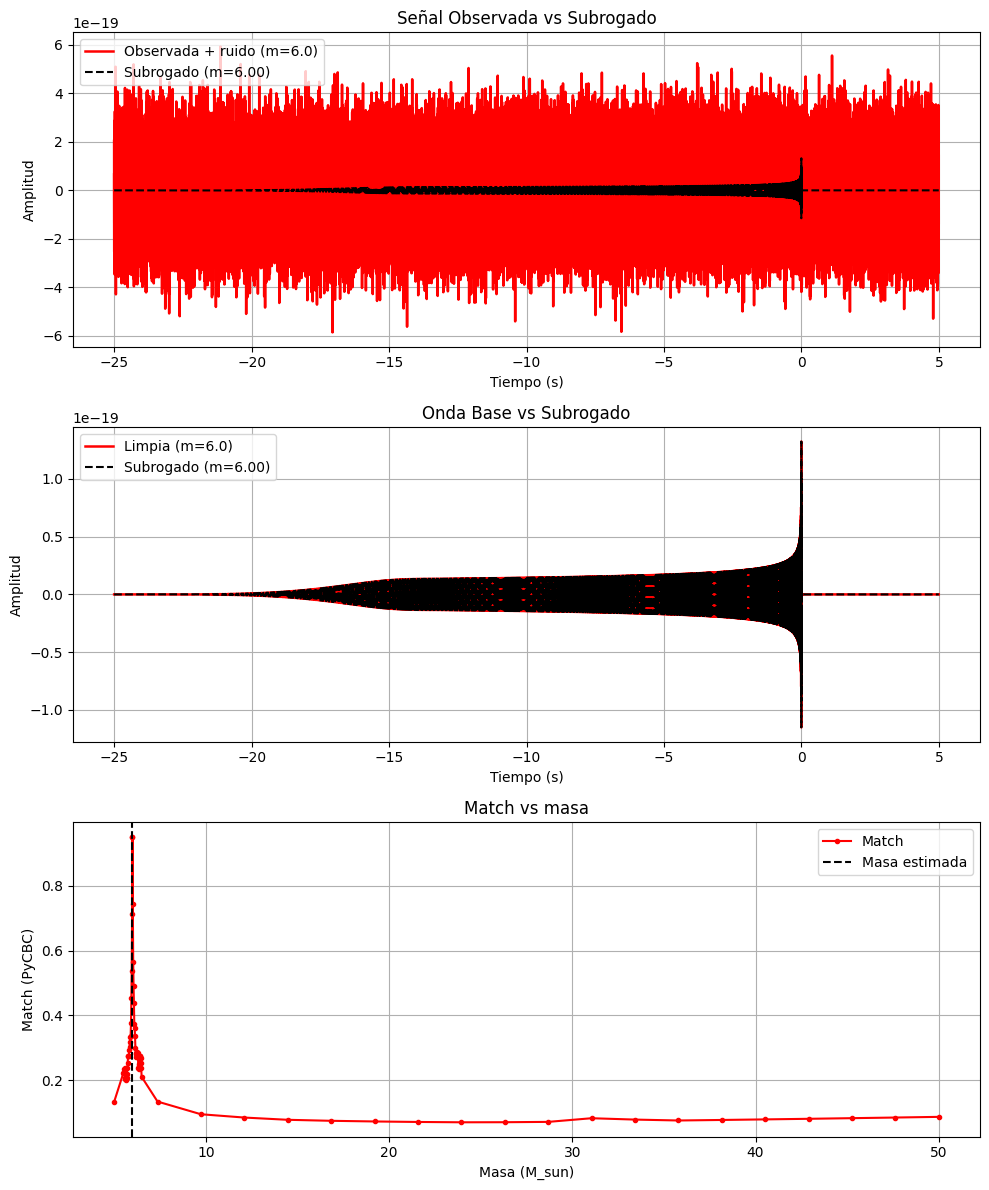

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Compatibilidad tukey (SciPy nuevo/viejo) ---
try:
    from scipy.signal.windows import tukey
except ImportError:
    from scipy.signal import get_window
    def tukey(M, alpha=0.1):
        return get_window(("tukey", alpha), M)

from scipy.signal import butter, filtfilt
from scipy.interpolate import PchipInterpolator

from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.types import TimeSeries
from pycbc.psd import aLIGOZeroDetHighPower

# ================================
# Configuración y toggles
# ================================
np.random.seed(42)

delta_t = 1.0 / 4096.0
f_low = 20.0
f_high = 512.0       # corte alto para la métrica
apx = "SEOBNRv4_ROM"

# Ventana temporal más larga (más inspiral útil)
T_BEFORE = 25.0
T_AFTER  = 5.0

# Taper más suave
TAPER_ALPHA = 0.02

# Varianza explicada de la base reducida
ENERGY_TARGET = 0.999

# Refinar malla alrededor de 6
COARSE_POINTS = 20
FINE_MIN, FINE_MAX, FINE_STEP = 5.5, 6.5, 0.02

# Mejoras activables
USE_BANDPASS      = True   # aplica band-pass SOLO para la métrica
USE_PROJECTION    = True   # proyecta observada en la base (denoise) para la métrica
ZERO_PAD_FACTOR   = 2      # 1 = sin zero-padding; 2 = duplica longitud para métrica

# ================================
# Utilidades
# ================================
def safe_time_slice(h, t_before=T_BEFORE, t_after=T_AFTER):
    """Centra en el pico de |h| y recorta ventana alrededor."""
    t_peak = h.sample_times[np.argmax(np.abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

def taper_arr(arr, alpha=TAPER_ALPHA):
    """Ventaneo Tukey leve para evitar bordes."""
    if alpha and alpha > 0:
        w = tukey(len(arr), alpha=alpha)
        return arr * w
    return arr

def preprocess_raw(h_ts, N):
    """
    Preprocesado 'crudo':
    - pad/trunc a N
    - taper leve
    - SIN blanqueo, SIN normalización (preserva escala/fase)
    """
    arr = h_ts.numpy()
    out = np.zeros(N, dtype=float)
    L = min(len(arr), N)
    out[:L] = arr[:L]
    out = taper_arr(out, alpha=TAPER_ALPHA)
    return out

def choose_k_by_energy(S, energy=ENERGY_TARGET):
    cum = np.cumsum(S**2) / np.sum(S**2)
    return int(np.searchsorted(cum, energy) + 1)

def bandpass(arr, fs, f1=f_low, f2=f_high, order=4):
    """Band-pass Butterworth para la MÉTRICA (no para plots/entrenamiento)."""
    nyq = 0.5 * fs
    b, a = butter(order, [f1/nyq, f2/nyq], btype='band')
    return filtfilt(b, a, arr)

def pad_to_length(x, M):
    out = np.zeros(M, dtype=float)
    L = min(len(x), M)
    out[:L] = x[:L]
    return out

def project_onto_basis(x, B):
    """
    Proyección ortogonal en el subespacio de la base reducida.
    Si B = U (SVD), sus columnas son ortonormales: P ≈ B B^T.
    """
    return B @ (B.T @ x)

# ================================
# Señal objetivo (m=6) y observada con ruido fuerte
# ================================
m_real = 6.0
hp_clean, _ = get_td_waveform(approximant=apx,
                              mass1=m_real, mass2=m_real,
                              delta_t=delta_t, f_lower=f_low)
hp_clean = safe_time_slice(hp_clean)
hp_clean_np = hp_clean.numpy()
times = hp_clean.sample_times.numpy()
N = len(hp_clean_np)

# Ruido con sigma = amplitud pico (SNR ~ 1)
sigma_noise = np.max(np.abs(hp_clean_np))
noise = np.random.normal(0.0, sigma_noise, size=N)
hp_obs = hp_clean_np + noise   # <-- señal observada ORIGINAL (para Gráfico 1)

# ================================
# Conjunto de masas (más denso cerca de 6)
# ================================
mass_coarse = np.linspace(5.0, 50.0, COARSE_POINTS)
mass_fine   = np.arange(FINE_MIN, FINE_MAX + 1e-9, FINE_STEP)
mass_range  = np.unique(np.concatenate([mass_coarse, mass_fine, [6.0]]))

# ================================
# Matriz W (ondas crudas preprocesadas: mismo recorte + taper leve)
# ================================
W_list = []
for m in mass_range:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h)
    h_arr = preprocess_raw(h, N)
    W_list.append(h_arr)
W = np.array(W_list).T  # [N x n_mass]

# ================================
# Base reducida (SVD) en dominio crudo
# ================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = choose_k_by_energy(S, energy=ENERGY_TARGET)
basis = U[:, :k]                 # [N x k]
coeffs = basis.T @ W             # [k x n_mass]

# ================================
# Interpolación PCHIP de coeficientes vs masa
# ================================
interp_list = []
for i in range(k):
    pchip = PchipInterpolator(mass_range, coeffs[i, :], extrapolate=True)
    interp_list.append(pchip)

def surrogate_raw(m):
    """Predice h_cruda(m) (mismo recorte/taper, sin blanqueo/normalización)."""
    coeff_pred = np.array([p(m) for p in interp_list])   # [k]
    return basis @ coeff_pred                            # [N]

# ================================
# Preparar series para la MÉTRICA (band-pass / proyección / padding)
# ================================
fs = 1.0 / delta_t

# Observada para la métrica:
obs_for_metric = hp_obs.copy()
if USE_PROJECTION:
    obs_for_metric = project_onto_basis(obs_for_metric, basis)
if USE_BANDPASS:
    obs_for_metric = bandpass(obs_for_metric, fs, f1=f_low, f2=f_high)

M = int(ZERO_PAD_FACTOR * N)
if ZERO_PAD_FACTOR > 1:
    obs_for_metric = pad_to_length(obs_for_metric, M)

ts_obs = TimeSeries(obs_for_metric, delta_t=delta_t)
flen = len(ts_obs) // 2 + 1
psd = aLIGOZeroDetHighPower(flen, ts_obs.delta_f, f_low)

# ================================
# Barrido de masas y match real (PyCBC)
# ================================
start_sub = time.time()
matches = []
for m in mass_range:
    h_try = surrogate_raw(m)
    # Solo para la métrica:
    if USE_BANDPASS:
        h_try = bandpass(h_try, fs, f1=f_low, f2=f_high)
    if ZERO_PAD_FACTOR > 1:
        h_try = pad_to_length(h_try, M)
    ts_try = TimeSeries(h_try, delta_t=delta_t)
    mm, _ = match(ts_obs, ts_try, psd=psd,
                  low_frequency_cutoff=f_low,
                  high_frequency_cutoff=f_high)
    matches.append(mm)
time_sub = time.time() - start_sub

best_idx = int(np.argmax(matches))
m_est = float(mass_range[best_idx])
best_match = float(matches[best_idx])
error_m = abs(m_est - m_real)

# ================================
# Tiempos de referencia
# ================================
start_exact = time.time()
h_exact, _ = get_td_waveform(approximant=apx,
                             mass1=m_real, mass2=m_real,
                             delta_t=delta_t, f_lower=f_low)
h_exact = safe_time_slice(h_exact)
h_exact_arr = preprocess_raw(h_exact, N)
time_exact = time.time() - start_exact

# Coste "online" puro del surrogate
m_test = 6.3
t0 = time.time()
h_pred_test = surrogate_raw(m_test)
t1 = time.time()
# métrica (misma preparación que arriba)
if USE_BANDPASS:
    h_pred_metric = bandpass(h_pred_test, fs, f1=f_low, f2=f_high)
else:
    h_pred_metric = h_pred_test
if ZERO_PAD_FACTOR > 1:
    h_pred_metric = pad_to_length(h_pred_metric, M)
_ = match(ts_obs, TimeSeries(h_pred_metric, delta_t=delta_t),
          psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)
t2 = time.time()
time_surrogate_only = t1 - t0
time_compare_only   = t2 - t1

# ================================
# Resultados
# ================================
print("=== Resultados ===")
print(f"TAPER_ALPHA: {TAPER_ALPHA} | ENERGY_TARGET: {ENERGY_TARGET}")
print(f"Dimensión base (k): {k}")
print(f"Band-pass métrico: {USE_BANDPASS} | Proyección (denoise): {USE_PROJECTION} | Zero-pad x{ZERO_PAD_FACTOR}")
print(f"Masa real: {m_real:.3f}")
print(f"Masa estimada (subrogado): {m_est:.3f}")
print(f"Error en estimación: {error_m:.4f} M_sun")
print(f"Mejor match (PyCBC): {best_match:.4f}")
print(f"Tiempo barrido subrogado (todas las m): {time_sub:.4f} s")
print(f"Tiempo surrogate(m) puro: {time_surrogate_only:.6f} s | comparar: {time_compare_only:.6f} s")
print(f"Tiempo exacto (generación de onda): {time_exact:.4f} s")

# ================================
# Gráficos — ¡OJO! Gráfico 1 es Observada ORIGINAL vs Subrogado
# ================================
plt.figure(figsize=(10, 12))

# 1) Observada ORIGINAL vs Subrogado (m_est)
plt.subplot(3, 1, 1)
plt.plot(times, hp_obs,color='red', label=f"Observada + ruido (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate_raw(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal Observada vs Subrogado")
plt.legend()
plt.grid(True)

# 2) Limpia ORIGINAL vs Subrogado (ambas mismo recorte/taper)
plt.subplot(3, 1, 2)
plt.plot(times, hp_clean_np,color='red', label=f"Limpia (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate_raw(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Onda Base vs Subrogado")
plt.legend()
plt.grid(True)

# 3) Match vs masa (PyCBC)
plt.subplot(3, 1, 3)
plt.plot(mass_range, matches, "-o", ms=3,color="red", label="Match")
plt.axvline(m_est, linestyle="--",color='black', label="Masa estimada")
plt.xlabel("Masa (M_sun)")
plt.ylabel("Match (PyCBC)")
plt.title("Match vs masa")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
